(512, 512, 100)


dtype('<f8')

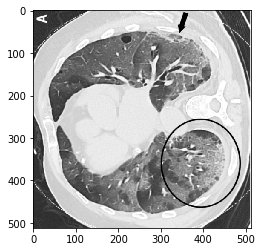

In [1]:
#importing useful libraries
import os
import nibabel as nib
import matplotlib.pyplot as plt
from skimage import exposure, img_as_uint
import cv2
import numpy as np

dataTrain = nib.load('tr_im.nii.gz')
dataMaskTrain = nib.load('tr_mask.nii.gz')
dataTest = nib.load('val_im.nii.gz')

#print info of arrays from dataTrain
print(dataTrain.shape)

#showing an particular image of dataTrain
plt.imshow(dataTrain.get_fdata()[:,:,60],cmap='gray')

#create a z variable to see the type of the matrix (values)
z = dataTrain.get_fdata()[:,:,60]
z.dtype

In [2]:
#function to show n images
def showImages(images, rows, cols):
    plt.figure(figsize = (16,16))
    for i in range (rows*cols):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title('Lung')
        plt.xticks(())
        plt.yticks(())

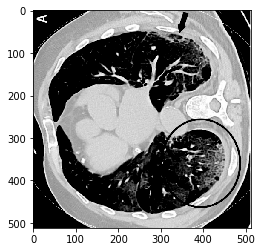

In [3]:
#what happens if we rescale the previous image and show
zNew = img_as_uint(exposure.rescale_intensity(z))
plt.imshow(zNew,cmap='gray')
#clearly the result is not desirable 

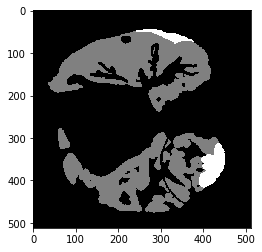

In [4]:
#showing the mask of the same image
plt.imshow(dataMaskTrain.get_fdata()[:,:,60],cmap='gray')

In [5]:
#function to convert the space or values of the original images into a new values
#using the original values. This is like a transformation from a matrix type float to
#uint8
def convert(img, targetTypeMin, targetTypeMax, targetType):
    imin = img.min()
    imax = img.max()

    a = (targetTypeMax - targetTypeMin) / (imax - imin)
    b = targetTypeMax - a * imax
    newImg = (a * img + b).astype(targetType)
    return newImg

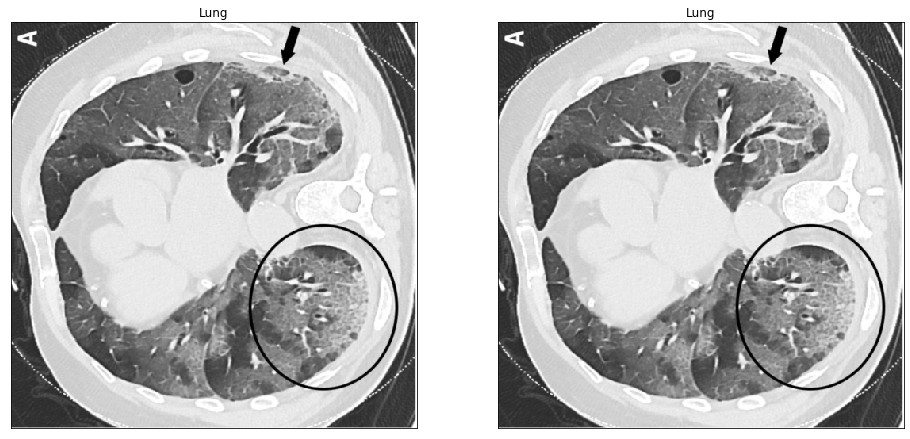

In [6]:
#we transform the previous image using the function convert and compare visualy
#the result vs the original. The transformation was into uint64 
transform = convert(z,np.iinfo(np.uint64).min,np.iinfo(np.uint64).max,np.uint64)
list1 = [z,transform]
showImages(list1,1,2)

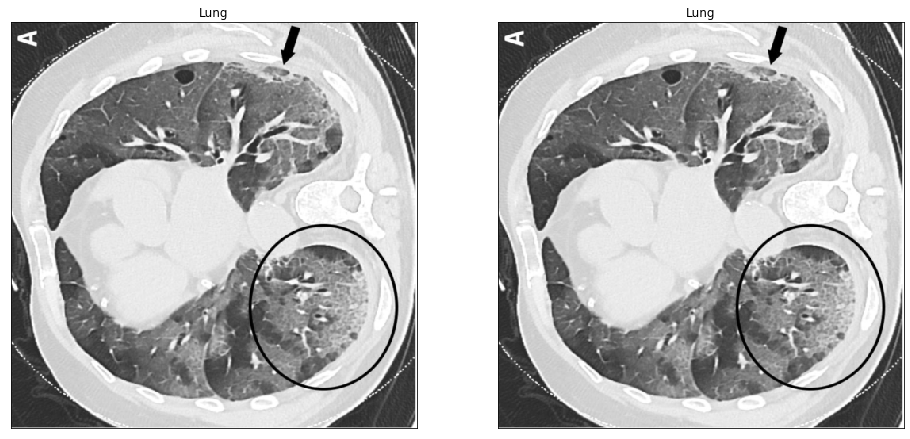

In [7]:
#Transforming into uint32
transform2 = convert(z,np.iinfo(np.uint32).min,np.iinfo(np.uint32).max,np.uint32)
list2 = [z,transform2]
showImages(list2,1,2)

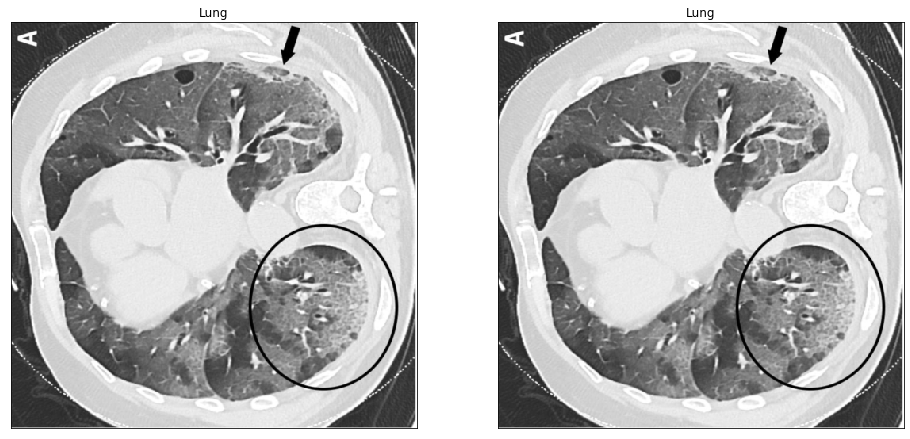

In [8]:
#Transforming into uint16
transform3 = convert(z,np.iinfo(np.uint16).min,np.iinfo(np.uint16).max,np.uint16)
list3 = [z,transform3]
showImages(list3,1,2)

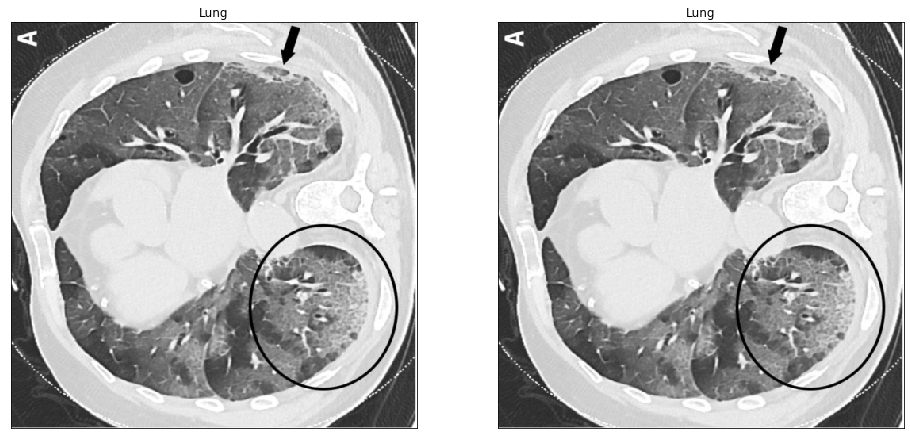

In [9]:
#Transforming into uint8
transform4 = convert(z,np.iinfo(np.uint8).min,np.iinfo(np.uint8).max,np.uint8)
list4 = [z,transform4]
showImages(list4,1,2)

## It looks like there's no big difference between the original image and the transformed image, so we'll be using the transformation of uint8.

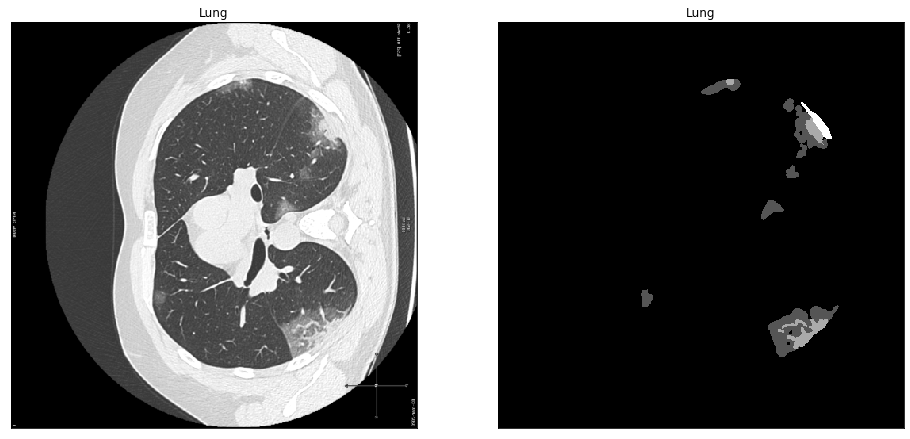

In [10]:
#we see the original image and its mask
list21 = [dataTrain.get_fdata()[:,:,63],dataMaskTrain.get_fdata()[:,:,63]]
showImages(list21,1,2)

In [11]:
#searching for the indexes of type 1 in a particular mask
A = np.where(dataMaskTrain.get_fdata()[:,:,63]==1)
A

(array([ 72,  72,  72, ..., 422, 422, 422], dtype=int64),
 array([297, 298, 299, ..., 358, 359, 360], dtype=int64))

In [12]:
##searching for the indexes of type 2 in the same mask as before
B =np.where(dataMaskTrain.get_fdata()[:,:,63]==2)
B

(array([ 72,  72,  72, ..., 411, 411, 412], dtype=int64),
 array([289, 290, 291, ..., 376, 377, 374], dtype=int64))

In [13]:
#are the types 1 and 2 superimposed? Answer NO 
np.array_equal(A,B)

False

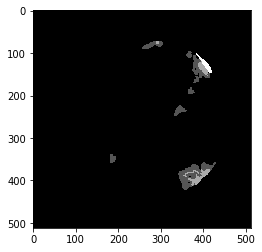

In [14]:
#creating a new variable to obtain the data of a certain image to modify its values for segmentation
copy = dataMaskTrain.get_fdata()[:,:,63]
cop = dataTrain.get_fdata()[:,:,63]
plt.imshow(copy,cmap='gray')

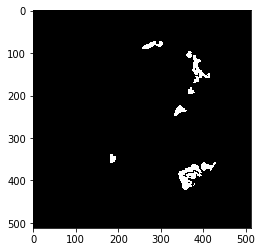

In [15]:
#in the copy image search the values different from 1 and make it zero
#i.e. obtain de mask with value 1 and show it
z = np.where(copy!=1)
copy[z] = 0
plt.imshow(copy,cmap='gray')

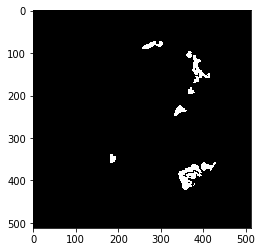

In [16]:
#if we search from the copy the values of type 3 we obtain the same result as before
z = np.where(copy==3)
copy[z]=0
plt.imshow(copy,cmap='gray')
w = np.multiply(copy, cop)

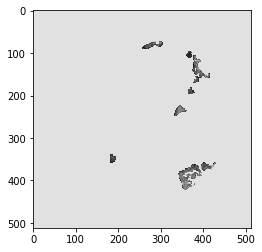

In [17]:
plt.imshow(w,cmap='gray')
plt.show()

if we create a new variable wich contains the value of a mask (e.g dataMaskTrain.get_fdata()[:,:,63]) and we modify the values of the new variable, then the original value of the mask will be modified too. So, to obtain the masked images we need to read the mask more than once.

In [18]:
#with this block of code we obtain the masked images
#creating lists to save the mask of each type
listForType1 = []
listForType2 = []
listForType3 = []
#iterating over all images
for i in range(100):
    #iterating over the types
    for j in range(1,4,1):
        #as we have seen if we modify the mask the info will loose. Therefore we need read each time we modify it
        dataMaskTrain = nib.load('tr_mask.nii.gz')
        #create a copy of the image mask
        copy = dataMaskTrain.get_fdata()[:,:,i]
        #search for the indexes that are not equal to the current type
        index = np.where(copy!=j)
        #fit the image in these indexes to zero
        copy[index]=0
        #if the lenght of the indexes are equal to the lenght of the image
        #pass the next lines of code
        if (len(index[0])==262144):
            continue
        #make the multiplication entry by entry of the copy divided by its type (norm 1) with the original image
        masked = np.multiply(copy/j, dataTrain.get_fdata()[:,:,i])
        #append in its corresponding list
        if (j==1):
            listForType1.append(masked)
        elif (j==2):
            listForType2.append(masked)
        else:
            listForType3.append(masked)
        

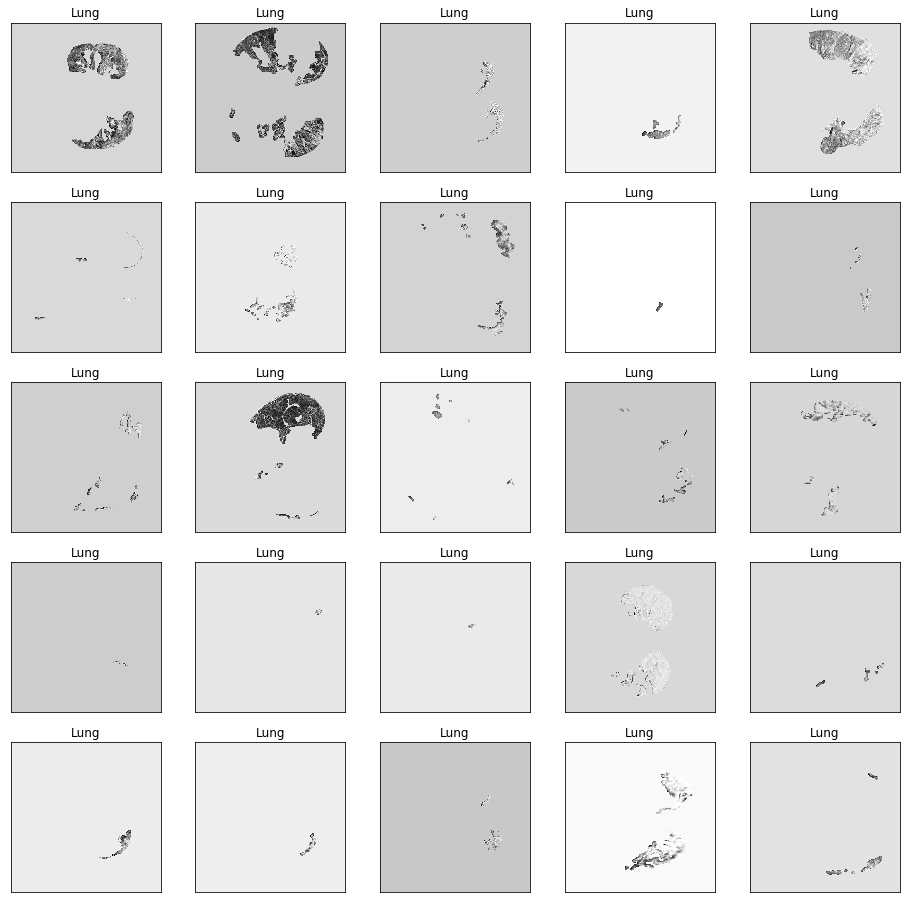

In [19]:
#Use the function showImages to see the results
showImages(listForType2[:25],5,5)

In [20]:
#What's the lenght of type3
len(listForType3)

25

In [21]:
#showing data to understand the difference between the expected results and the obtained results
dataMaskTrain.get_fdata()[:,:,1]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [22]:
dataTrain.get_fdata()[:,:,1]

array([[-1384.0450142 ,  -709.03224231,  -641.93249741, ...,
        -1473.23685546, -1475.95558574, -1477.68877538],
       [-1472.14320194, -1457.95137003, -1456.75001857, ...,
        -1474.51494082, -1476.20743522, -1477.69007278],
       [-1405.2018151 ,  -874.67424295,  -825.99078327, ...,
        -1476.07879934, -1476.69584862, -1477.68992255],
       ...,
       [-1477.69230769, -1477.69230769, -1477.69230769, ...,
         -302.79929586, -1416.65585615, -1477.68162238],
       [-1477.69230769, -1477.69230769, -1477.69230769, ...,
         -270.82359718, -1412.93897748, -1477.68232453],
       [-1477.69230769, -1477.69230769, -1477.69230769, ...,
         -882.31176939, -1464.63402547, -1477.68900034]])

In [23]:
listForType1[1]

array([[-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       ...,
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.]])

In [24]:
dataMaskTrain.get_fdata()[:,:,2]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [25]:
dataTrain.get_fdata()[:,:,2]

array([[ -391.83889037,  -391.83886865,  -391.65809951, ...,
         -400.5697067 ,  -401.36041591,  -401.58531635],
       [ -995.66581778,  -995.66590189,  -996.36603529, ...,
        -1018.54053668, -1015.47805638, -1014.60699888],
       [-1000.18580249, -1000.18582379, -1000.36307361, ...,
        -1020.33058533, -1019.5552701 , -1019.33474814],
       ...,
       [-1000.        , -1000.        , -1000.        , ...,
        -1019.14893617, -1019.14893617, -1019.14893617],
       [-1000.        , -1000.        , -1000.        , ...,
        -1019.14893617, -1019.14893617, -1019.14893617],
       [-1000.        , -1000.        , -1000.        , ...,
        -1019.14893617, -1019.14893617, -1019.14893617]])

In [26]:
listForType1[2]

array([[-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       ...,
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.]])

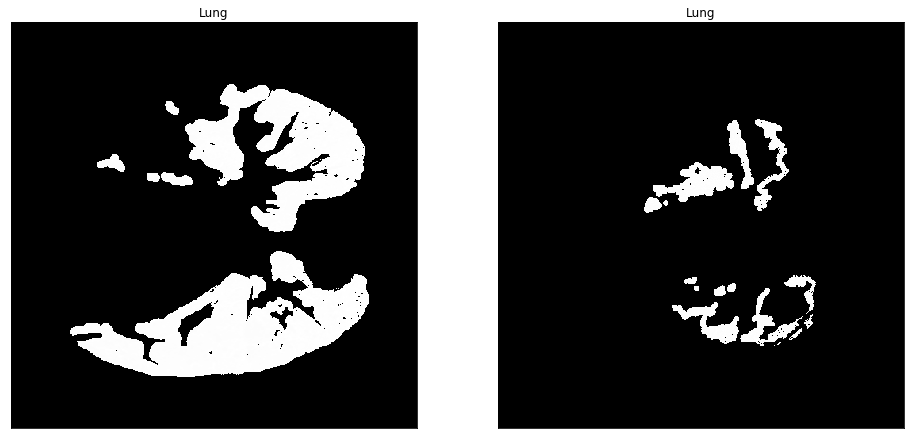

In [27]:
#if we transform the images into uint16 and see the result
tt = listForType1[3].astype('uint16')
ttt = listForType1[8].astype('uint16')
kk = [ttt,tt]
showImages(kk,1,2)

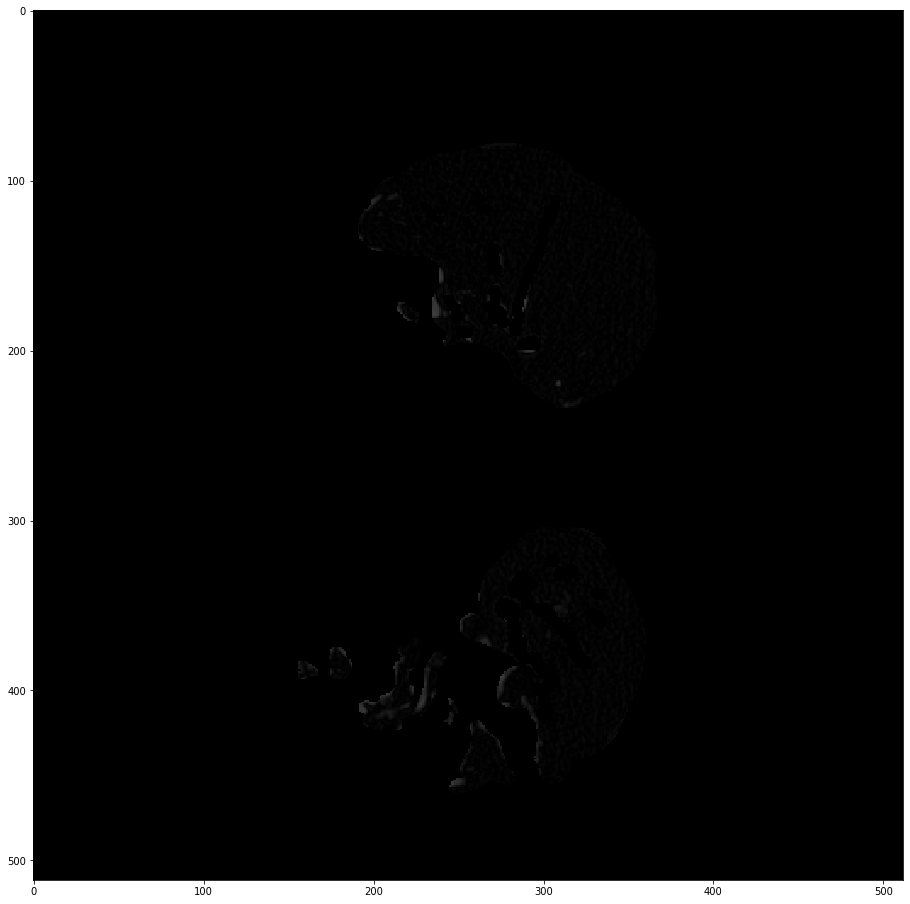

In [28]:
#changing the method to show the images
plt.figure(figsize = (16,16))
plt.imshow(np.absolute(listForType2[18]), cmap="gray", vmin=0, vmax=4096)
plt.show()

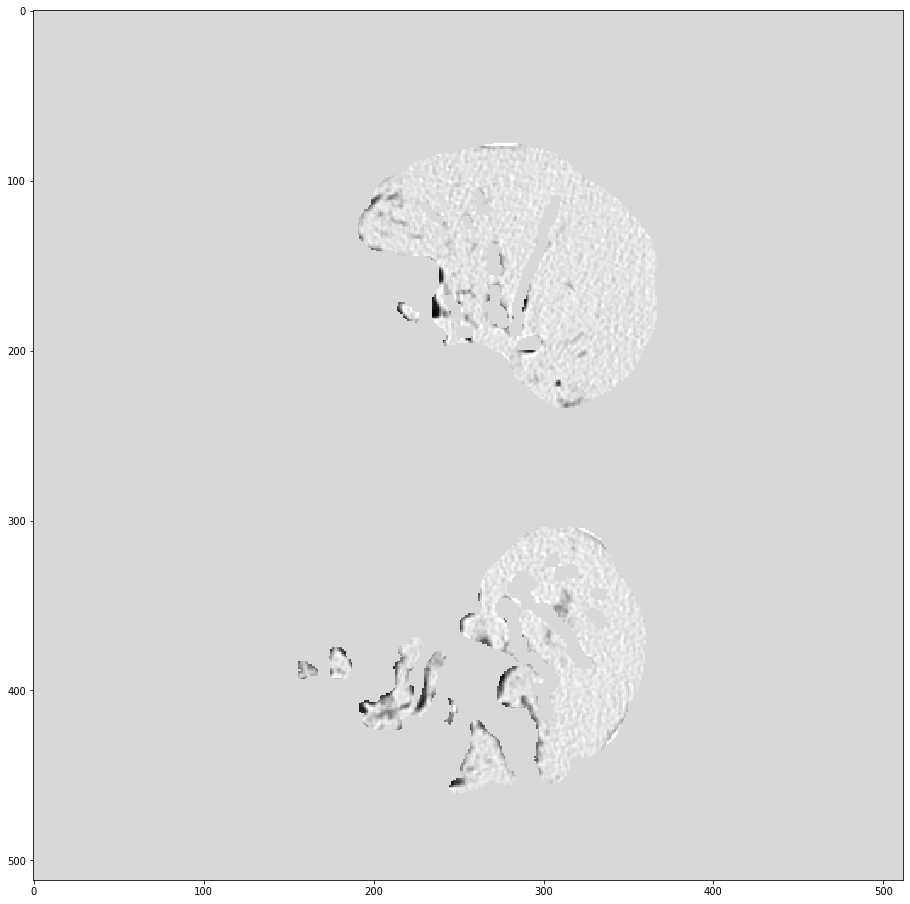

In [29]:
plt.figure(figsize = (16,16))
plt.imshow(listForType2[18], cmap="gray")#, vmin=0, vmax=4096)
plt.show()

In [30]:
#the problem was the scale of the images. So we transform it before we obtain the masks
transf = []
for i in range(100):
    transformation = convert(dataTrain.get_fdata()[:,:,i],np.iinfo(np.uint8).min,np.iinfo(np.uint8).max,np.uint8)
    transf.append(transformation)

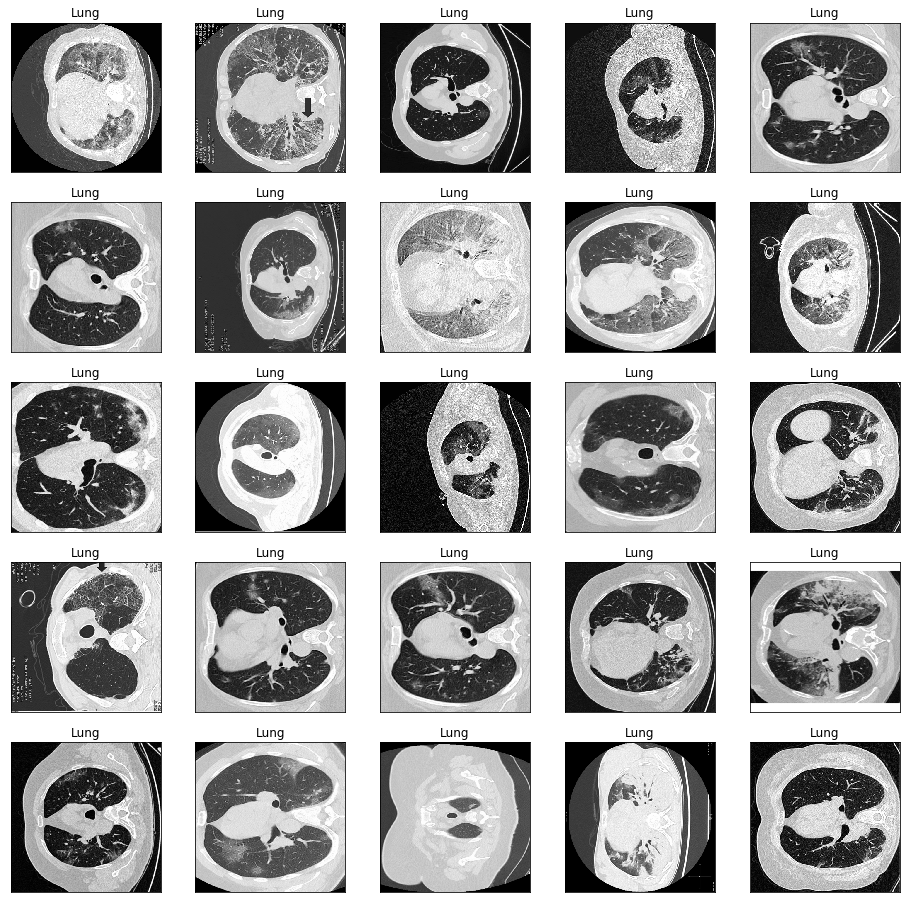

In [31]:
#showing the results
showImages(transf[:25],5,5)

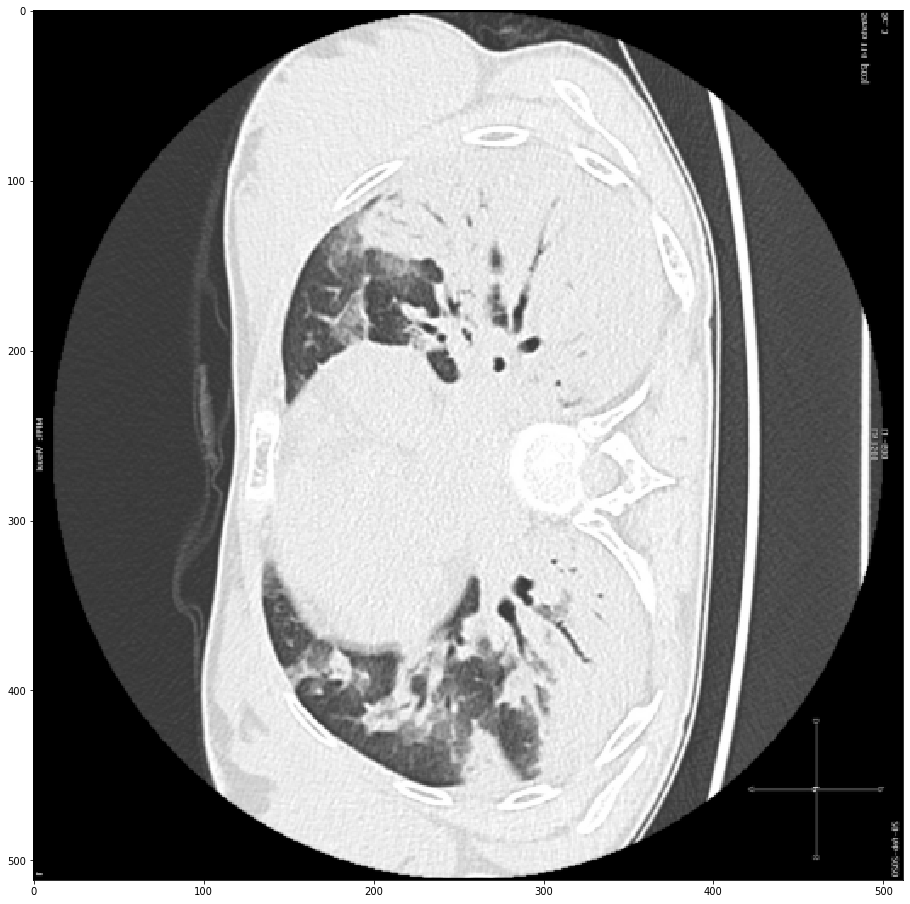

In [32]:
#comparing visualy the results with the original image
plt.figure(figsize = (16,16))
plt.imshow(transf[23], cmap="gray")#, vmin=0, vmax=4096)
plt.show()

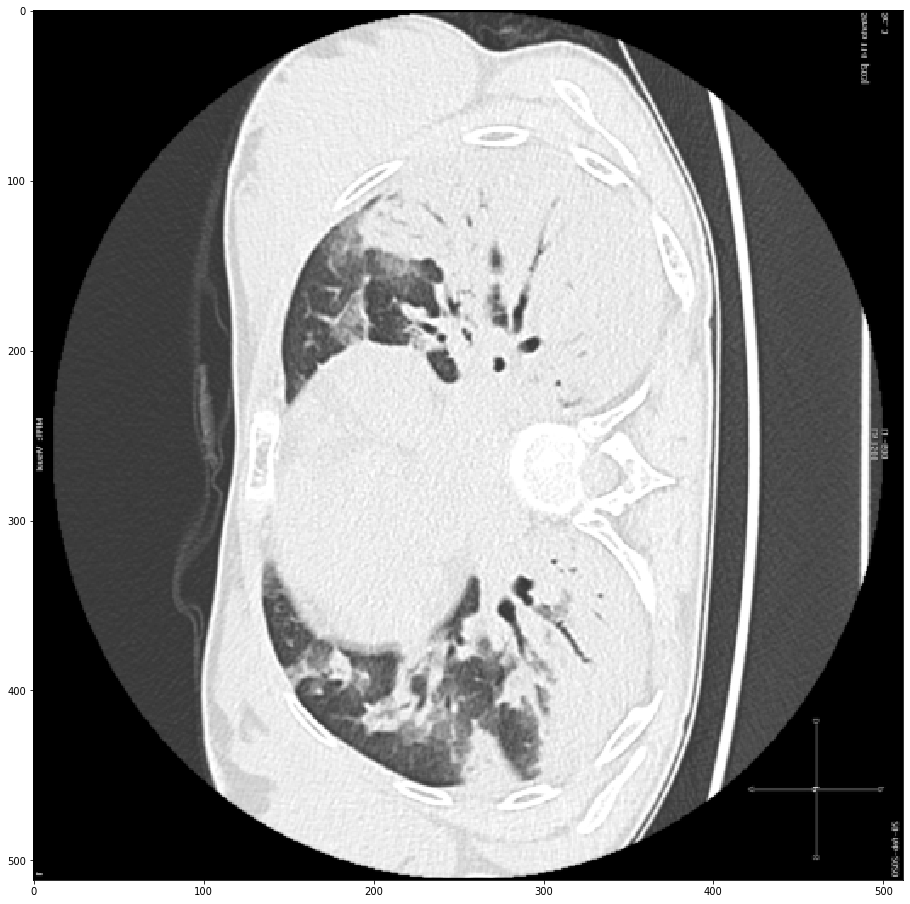

In [33]:
plt.figure(figsize = (16,16))
plt.imshow(dataTrain.get_fdata()[:,:,23], cmap="gray")#, vmin=0, vmax=4096)
plt.show()

In [34]:
#do the same as before to obtain the masks using the converted images
listForType1 = []
listForType2 = []
listForType3 = []
for i in range(100):
    for j in range(1,4,1):
        dataMaskTrain = nib.load('tr_mask.nii.gz')
        copy = dataMaskTrain.get_fdata()[:,:,i]
        index = np.where(copy!=j)
        copy[index]=0
        if (len(index[0])==262144):
            continue
        masked = np.multiply((copy/j), transf[i])
        masked = masked.astype(np.uint8)
        if (j==1):
            listForType1.append(masked)
        elif (j==2):
            listForType2.append(masked)
        else:
            listForType3.append(masked)

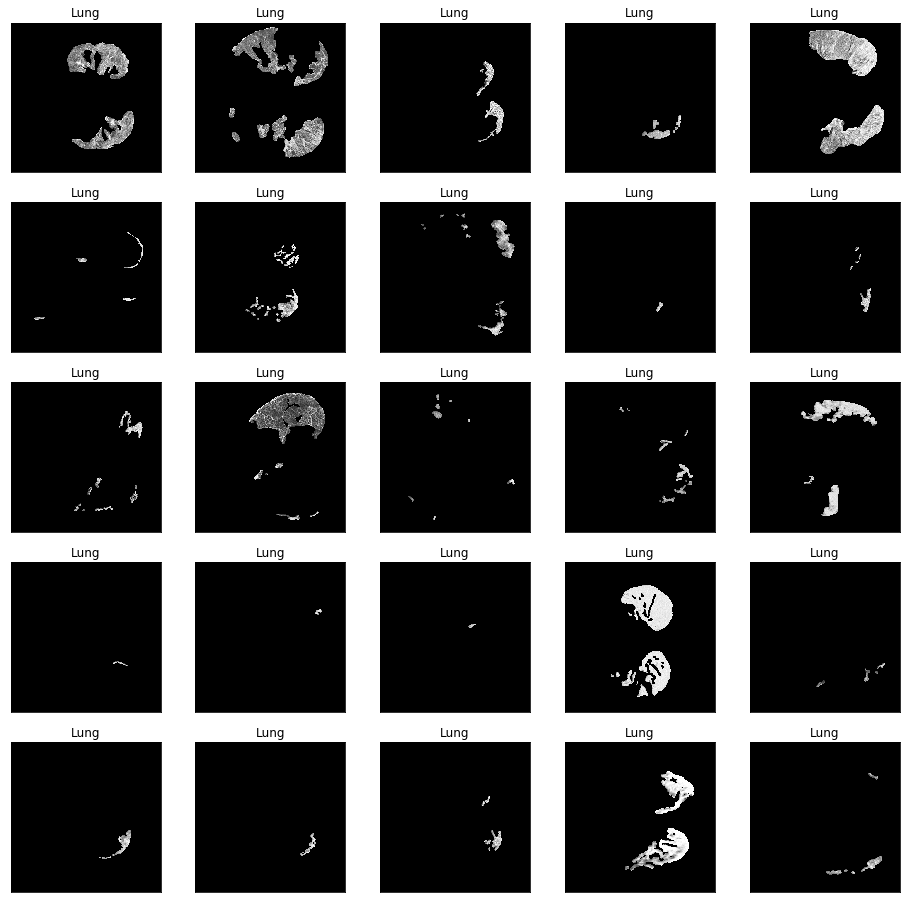

In [35]:
#we obtain the expected results
showImages(listForType2[:25],5,5)

In [36]:
len(listForType1)

96

In [37]:
#converting the test images and saving it into the TestImages Folder
transfTest = []
for i in range(10):
    transformationTest = convert(dataTest.get_fdata()[:,:,i],np.iinfo(np.uint8).min,np.iinfo(np.uint8).max,np.uint8)
    cv2.imwrite('TestImages/'+str(i)+'.png', transformationTest)

In [38]:
#function to obtain the texture propierties of each masked image using the GLCM method
from skimage.feature import greycomatrix
from skimage.feature import greycoprops
def getTextureProperties(maskedImages):
    propertyForType = np.zeros((len(maskedImages),6),dtype=float)
    for i in range(len(maskedImages)):
        GLCM = greycomatrix(maskedImages[i],distances=[1],angles=[0],symmetric=False,normed=True)
        GLCM = GLCM[1:,1:,:,:]
        contrast = greycoprops(GLCM,'contrast')
        dissimilarity = greycoprops(GLCM,'dissimilarity')
        homogeneity = greycoprops(GLCM,'homogeneity')
        asm = greycoprops(GLCM,'ASM')
        energy = greycoprops(GLCM,'energy')
        correlation = greycoprops(GLCM,'correlation')
        propertyForType[i] = (contrast,dissimilarity,homogeneity,asm,energy,correlation)
    return propertyForType

In [39]:
from sklearn import preprocessing
import pandas as pd
#instantiate the texture properties of each type (1,2,3) and preprocesing it using the function scale
#from scikit learn
type1 = getTextureProperties(listForType1)
#type1 = preprocessing.scale(type1)
type2 = getTextureProperties(listForType2)
#type2 = preprocessing.scale(type2)
type3 = getTextureProperties(listForType3)
#type3 = preprocessing.scale(type3)
#create dataframes from the texture properties
type1DataFrame = pd.DataFrame(type1)
type2DataFrame = pd.DataFrame(type2)
type3DataFrame = pd.DataFrame(type3)
#saving the data into .csv files
type1DataFrame.to_csv('type1.csv',index=False,header=False)
type2DataFrame.to_csv('type2.csv',index=False,header=False)
type3DataFrame.to_csv('type3.csv',index=False,header=False)